
$$\psi(x, t) = A \cdot e^{-\frac{(x - x_0)^2}{2\sigma^2}} \cdot e^{i(kx - \omega t)}$$

$$i \hbar \frac{{\partial \psi}}{{\partial t}} = -\frac{\hbar^2}{2m} (\frac{{\partial^2 \psi}}{{\partial x^2}} + \frac{{\partial^2 \psi}}{{\partial y^2}}) + V(x, y) \psi$$

In [24]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt

hbar = 0.6582119514
m = 0.5109989461

Lx, Ly = 10.0, 10.0
T = 10.0
dx, dy, dt = 0.5, 0.5, 0.5
x0, y0 = 0.0, 0.0

sigma_x, sigma_y = 1.0, 1.0
kx, ky = 10.0, 10.0

# 2D gaussian wave packet
def psi0_2D(x0, y0, sigma_x, sigma_y, kx, ky, A, Nx, Ny):
    x, y = np.meshgrid(np.linspace(-Ly/2, Ly/2, Ny), np.linspace(-Ly/2, Ly/2, Nx))
    envelope = np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2)))
    phase = np.exp(1j * (kx * (x - x0) + ky * (y - y0)))
    psi = (A * envelope * phase)
    return psi

# infinite square well potential
def V_2d(Nx, Ny):
    V = np.zeros((Nx, Ny))
    for i in range(Nx):
        for j in range(Ny):
            if (i == 0 or i == Nx - 1 or j == 0 or j == Ny - 1):
                V[i, j] = 1e10
    V = V.flatten()
    return V

# Crank-Nicholson algorithm for solving the Schrödinger equation
def crank_nicholson(Nx, Ny, dx, dy, dt, V, psi):
    # reshape psi
    psi = psi.flatten()

    # Calculate the coefficients
    alpha_x = (1j * dt / (4 * dx**2))*(hbar**2 / (2 * m))
    alpha_y = 1j * dt / (4 * dy**2)*(hbar**2 / (2 * m))

    # AX = MY
    for i in range(1, Nx*Ny):
        # Construct A
        A = np.diag(1 + 2*alpha_x + 2*alpha_y + 0.5j*dt*V)  # diagonal
        A += np.diag(-alpha_x * np.ones(Nx*Ny - 1), 1)  # upper diagonal
        A += np.diag(-alpha_x * np.ones(Nx*Ny - 1), -1)  # lower diagonal
        A += np.diag(-alpha_y * np.ones((Nx-1)*Ny), Ny)  # upper diagonal
        A += np.diag(-alpha_y * np.ones((Nx-1)*Ny), -Ny)  # lower diagonal

        # Construct M
        M = np.diag(1 - 2*alpha_x - 2*alpha_y - 0.5j*dt*V)
        M += np.diag(alpha_x * np.ones(Nx*Ny - 1), 1)
        M += np.diag(alpha_x * np.ones(Nx*Ny - 1), -1)
        M += np.diag(alpha_y * np.ones((Nx-1)*Ny), Ny)
        M += np.diag(alpha_y * np.ones((Nx-1)*Ny), -Ny)
    print(A.shape, M.shape, psi.shape)
    # Solve the linear system
    A = csc_matrix(A)
    psi = spsolve(A, np.dot(M, psi))
    psi = psi.reshape(Nx, Ny)
    return psi

def time_evolution(dx, dy, dt, T, Lx, Ly, sigma_x, sigma_y, kx, ky, x0, y0):
    Nx = int(Lx/dx) + 1
    Ny = int(Ly/dy) + 1
    V = V_2d(Nx, Ny)
    psi = psi0_2D(x0, y0, sigma_x, sigma_y, kx, ky, 1, Nx, Ny)
    Psi = []
    t = 0.0
    while t < T:
        Psi.append((t, psi))
        psi = crank_nicholson(Nx, Ny, dx, dy, dt, V, psi)
        t += dt
    return Psi

Psi = time_evolution(dx, dy, dt, T, Lx, Ly, sigma_x, sigma_y, kx, ky, x0, y0)

(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)
(441, 441) (441, 441) (441,)


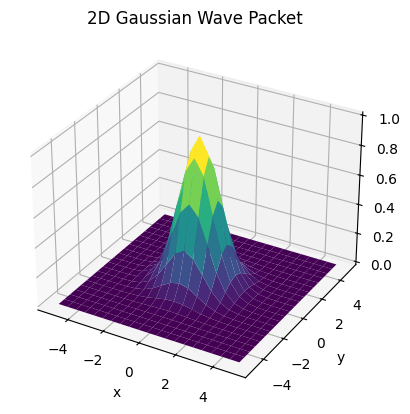

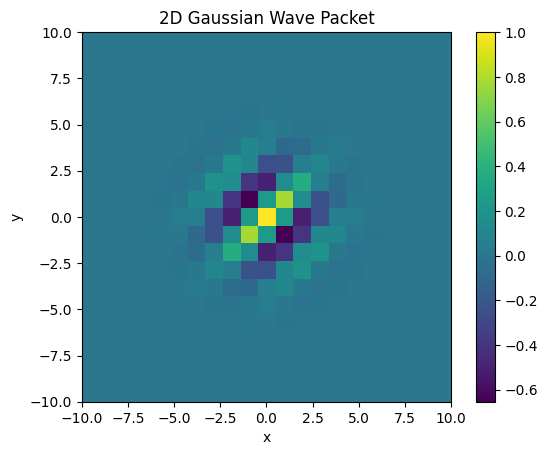

In [25]:
# 3D plot
psi = Psi[0][1]
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.linspace(-Lx/2, Lx/2, int(Lx/dx) + 1)
Y = np.linspace(-Ly/2, Ly/2, int(Ly/dy) + 1)
X, Y = np.meshgrid(X, Y)
ax.plot_surface(X, Y, np.abs(psi), cmap='viridis', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('2D Gaussian Wave Packet')
plt.show()

# 2D plot
plt.imshow(np.real(psi), extent=[-10, 10, -10, 10])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Gaussian Wave Packet')
plt.show()

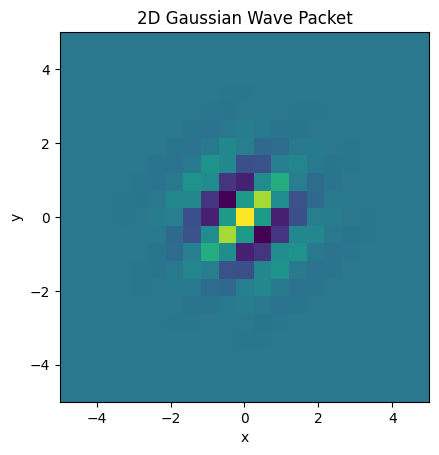

In [26]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.imshow(np.real(Psi[i][1]), extent=[-Lx/2, Lx/2, -Ly/2, Ly/2])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('2D Gaussian Wave Packet')
    ax.set_aspect('equal')
    ax.set_xlim(-Lx/2, Lx/2)
    ax.set_ylim(-Ly/2, Ly/2)

ani = FuncAnimation(fig, animate, frames=len(Psi), interval=100)
# Save the animation
ani.save('2D_Gaussian_Wave_Packet.gif', writer='pillow')

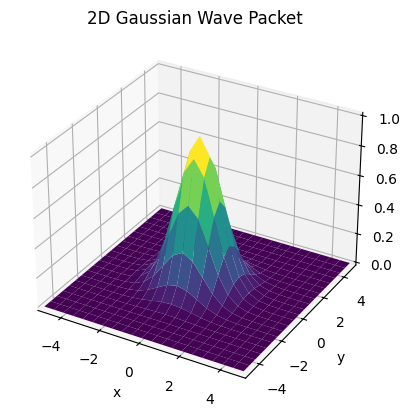

In [27]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def animate_3d(i):
    ax.clear()
    psi = Psi[i][1]
    ax.plot_surface(X, Y, np.abs(psi), cmap='viridis', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('2D Gaussian Wave Packet')
    ax.set_xlim(-Lx/2, Lx/2)
    ax.set_ylim(-Ly/2, Ly/2)
    ax.set_zlim(0, np.max(np.abs(Psi[0][1])))

ani_3d = FuncAnimation(fig, animate_3d, frames=len(Psi), interval=100)
# Save the animation
ani_3d.save('3D_Gaussian_Wave_Packet.gif', writer='pillow')
